---
format:
    html:
        embed-resources: true
---

In [119]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [120]:
trip = pd.read_csv("../../data/clean/trip.csv")

# Drop any columns with the string "id" or "flag" in them
for col in trip:
  if "id" in col or "flag" in col:
    trip = trip.drop(col, axis=1)

# Drop these columns: reason_for_travel', 'reason_for_travel_to', 'why_trip', 'trip_purpose_old_schema'
trip = trip.drop(['reason_for_travel', 'reason_for_travel_to', 'why_trip', 'trip_purpose_old_schema'], axis=1)

# Prepare trip data for model
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

for col in trip.columns.drop('trip_purpose'):
  if trip[col].dtype == object:
    trip[col] = label_encoder.fit_transform(trip[col])
  else: # Normalize
    trip[col] = scaler.fit_transform(trip[col].values.reshape(-1, 1))

# Remove rows where trip purpose is "Not Ascertained"
trip = trip[trip["trip_purpose"] != "Not ascertained"]
trip = trip.reset_index(drop=True)

vis = trip["trip_purpose"].astype('category')

trip["trip_purpose"] = label_encoder.fit_transform(trip["trip_purpose"])
target = trip["trip_purpose"].to_numpy()
features = trip.drop('trip_purpose', axis=1).to_numpy()

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


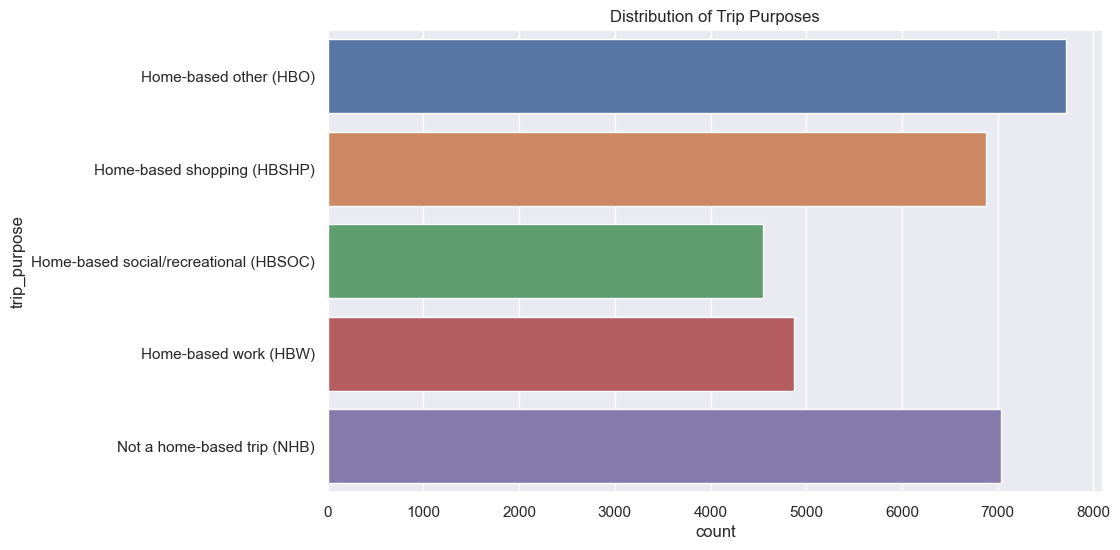

In [121]:
# Display distribution of original trip purposes as bar chart
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(y=vis)
plt.title("Distribution of Trip Purposes")
plt.show()

In [ ]:
# Train model with cross validation
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=1)

learning_rates = [0.1, 0.01, 0.001]
hidden_units = [512, 256, 128, 64, 32]
dropout = [0.0, 0.1, 0.2, 0.3]
activation = ["relu", "sigmoid", "tanh"]

# Set up cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)

batch = 64

# Train model with cross validation
results = []
for lr in learning_rates:
  for hu in hidden_units:
    for d in dropout:
        for act in activation:
            kf_results = []
            for train_index, test_index in kf.split(features):
                print(f"Training model with {lr}, {hu}, {d}, {act}")
                x_train, x_test = features[train_index], features[test_index]
                y_train, y_test = target[train_index], target[test_index]
        
                model = keras.Sequential()
                model.add(layers.Input(shape=(features.shape[1],)))
                if act == "relu":
                    model.add(layers.Dense(hu, activation='relu'))
                elif act == "sigmoid":
                    model.add(layers.Dense(hu, activation='sigmoid'))
                if d > 0:
                    model.add(layers.Dropout(d))
                model.add(layers.Dense(5, activation='softmax'))
                model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                model.fit(x_train, y_train, epochs=1000, batch_size=batch, callbacks=[callback], validation_data=(x_test, y_test))
                train_loss, train_accuracy = model.evaluate(x_train, y_train)
                loss, accuracy = model.evaluate(x_test, y_test)
                kf_results.append((train_accuracy, accuracy, train_loss, loss))
            results.append(
                {
                    "learning_rate": lr,
                    "hidden_units": hu,
                    "dropout": d,
                    "activation": act,
                    "train_accuracy": np.mean([r[0] for r in kf_results]),
                    "test_accuracy": np.mean([r[1] for r in kf_results]),
                    "train_loss": np.mean([r[2] for r in kf_results]),
                    "test_loss": np.mean([r[3] for r in kf_results])
                }
            )
            # Save results
            pd.DataFrame(results).to_csv("results4.csv", index=False)
            print(f"Accuracy: {np.mean([r[0] for r in kf_results])} - Loss: {np.mean([r[2] for r in kf_results])}")
            print(f"Val Accuracy: {np.mean([r[1] for r in kf_results])} - Val Loss: {np.mean([r[3] for r in kf_results])}")

In [99]:
results = pd.read_csv("results3.csv")

# Display results, sorted by test accuracy
results.sort_values(by="test_accuracy", ascending=False).head(10)

,learning_rate,hidden_units,dropout,activation,train_accuracy,test_accuracy,train_loss,test_loss
157,0.001,64,0.0,sigmoid,0.985370,0.972979,0.054781,0.084413
145,0.001,128,0.0,sigmoid,0.984718,0.969919,0.054775,0.095297
133,0.001,256,0.0,sigmoid,0.985145,0.969630,0.058285,0.100749
121,0.001,512,0.0,sigmoid,0.986546,0.968760,0.049717,0.100364
127,0.001,512,0.2,sigmoid,0.977576,0.964187,0.077677,0.116752
139,0.001,256,0.2,sigmoid,0.973349,0.964090,0.089051,0.121696
148,0.001,128,0.1,sigmoid,0.971490,0.963349,0.100531,0.125587
124,0.001,512,0.1,sigmoid,0.977351,0.963060,0.074840,0.117659
136,0.001,256,0.1,sigmoid,0.973776,0.962383,0.088757,0.124967
130,0.001,512,0.3,sigmoid,0.971602,0.961192,0.092711,0.126247


Index(['household_id', 'person_id', 'trip_id', 'sequential_trip_id',
       'time_at_destination', 'trip_duration_minutes', 'num_people_on_trip',
       'num_non_household_members_on_trip', 'num_household_members_on_trip',
       'parking_cost', 'trip_miles', 'trip_weight_7_day', 'trip_weight_5_day',
       'trip_weight_2_day', 'trip_case_id', 'vehicle_miles_traveled',
       'gas_price_at_travel_time', 'num_adults_in_household',
       'num_drivers_in_household', 'household_size',
       'num_vehicles_in_household', 'travel_day_date', 'WRKCOUNT',
       'household_stratum_id', 'respondent_age', 'household_grouping',
       'census_division', 'census_region', 'DRIVER', 'driver_flag',
       'education_level', 'end_trip_time', 'started_travel_at_home',
       'household_income', 'household_income_imputed', 'drove_on_trip',
       'hispanic', 'race', 'own_or_rent_home', 'LIF_CYC', 'loop_trip',
       'metro_area_category', 'metro_area_size', 'person_1_on_trip',
       'person_10_on_trip'

/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


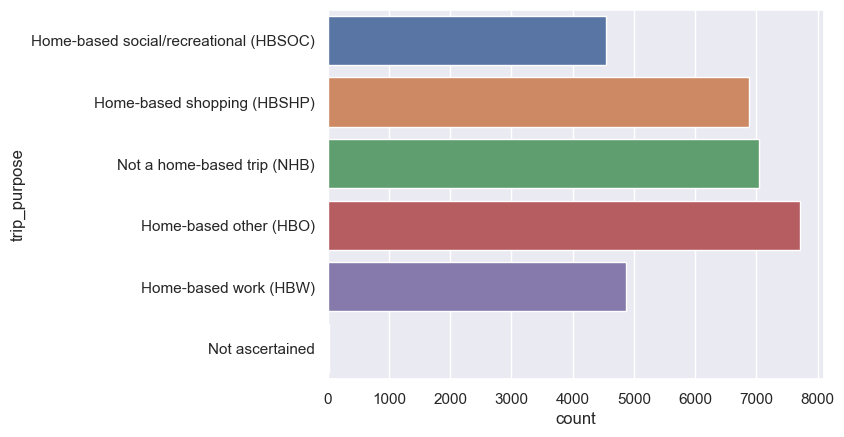

/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


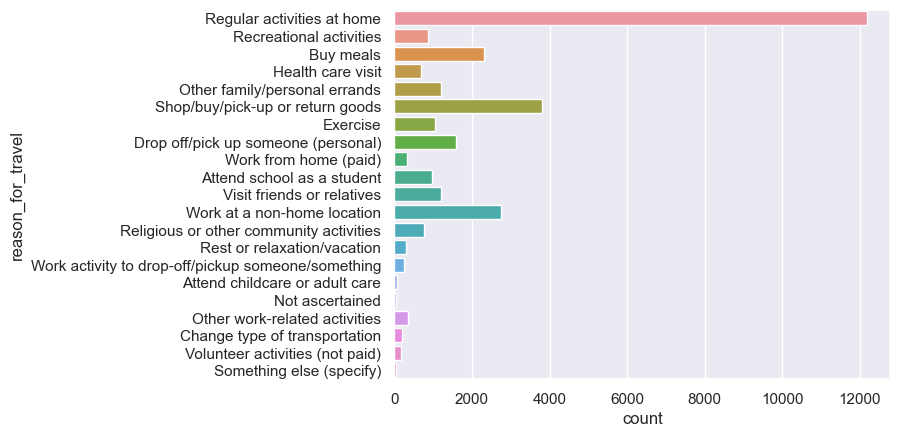

/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


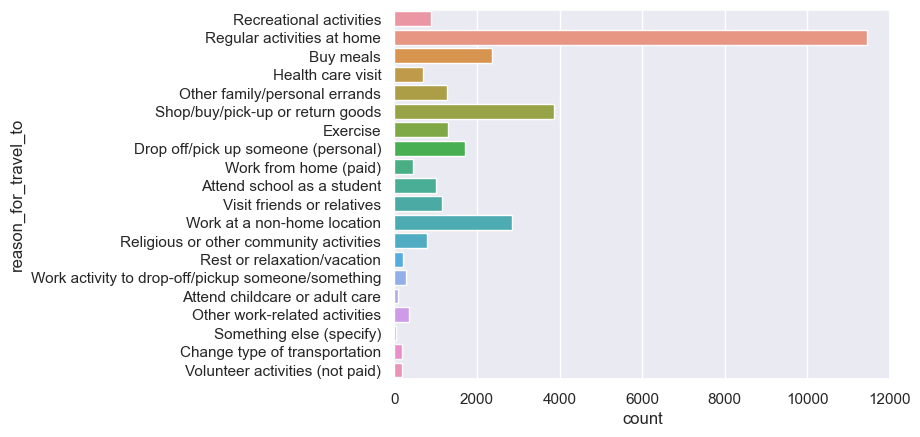

/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


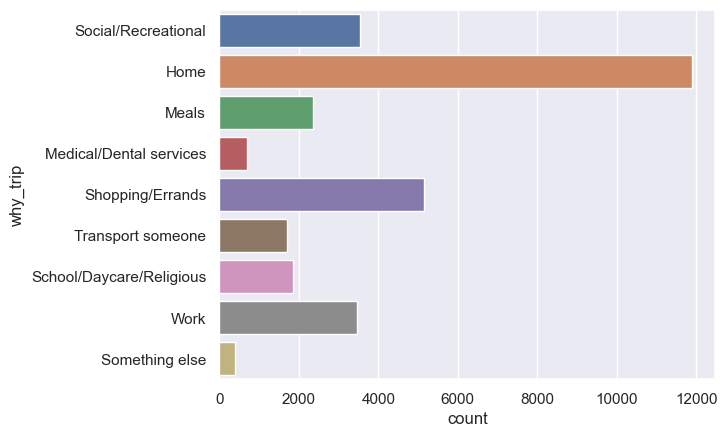

/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


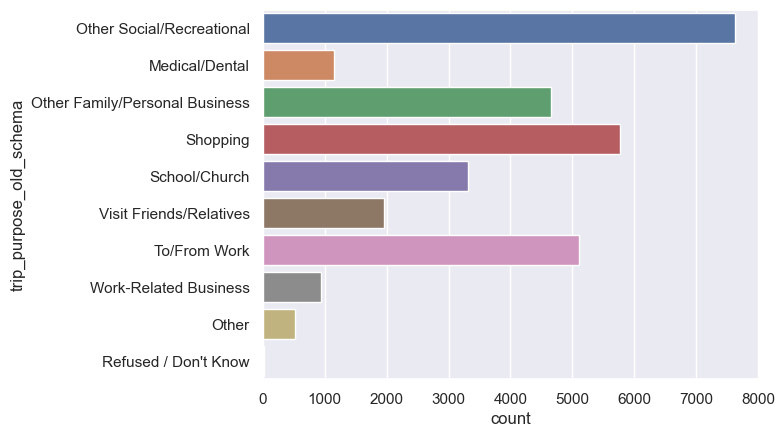

In [122]:
trip = pd.read_csv("../../data/clean/trip.csv")
print(trip.columns)

# Visualize the distribution of trip purposes
sns.countplot(y=trip["trip_purpose"])
plt.show()

sns.countplot(y=trip["reason_for_travel"])
plt.show()

sns.countplot(y=trip["reason_for_travel_to"])
plt.show()

sns.countplot(y=trip["why_trip"])
plt.show()

sns.countplot(y=trip['trip_purpose_old_schema'])
plt.show()


In [128]:
# Train neural network with best parameters
best_results = results.sort_values(by="test_accuracy", ascending=False).head(1).iloc[0]
print(best_results)

# Create validation data as 10% of training data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

model = keras.Sequential()
model.add(layers.Input(shape=(features.shape[1],)))
model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1000, batch_size=16, callbacks=[callback], validation_data=(x_val, y_val))

learning_rate        0.001
hidden_units            64
dropout                0.0
activation         sigmoid
train_accuracy     0.98537
test_accuracy     0.972979
train_loss        0.054781
test_loss         0.084413
Name: 157, dtype: object
Epoch 1/1000
825/825 [==============================] - 12s 12ms/step - loss: 1.4922 - accuracy: 0.3315 - val_loss: 1.4153 - val_accuracy: 0.3763
Epoch 2/1000
825/825 [==============================] - 6s 7ms/step - loss: 1.4061 - accuracy: 0.3761 - val_loss: 1.3813 - val_accuracy: 0.3920
Epoch 3/1000
825/825 [==============================] - 6s 7ms/step - loss: 1.3777 - accuracy: 0.3978 - val_loss: 1.4169 - val_accuracy: 0.3695
Epoch 4/1000
825/825 [==============================] - 6s 7ms/step - loss: 1.3571 - accuracy: 0.4005 - val_loss: 1.3673 - val_accuracy: 0.4172
Epoch 5/1000
825/825 [==============================] - 6s 7ms/step - loss: 1.3461 - accuracy: 0.4072 - val_loss: 1.3519 - val_accuracy: 0.4001
Epoch 6/1000
825/825 [===============

413/413 [==============================] - 2s 6ms/step - loss: 0.9968 - accuracy: 0.5975
Train Accuracy: 0.5975000262260437
46/46 [==============================] - 1s 18ms/step - loss: 1.3440 - accuracy: 0.4574
Validation Accuracy: 0.4573960602283478
Test Accuracy: 0.4475040137767792
413/413 [==============================] - 1s 2ms/step


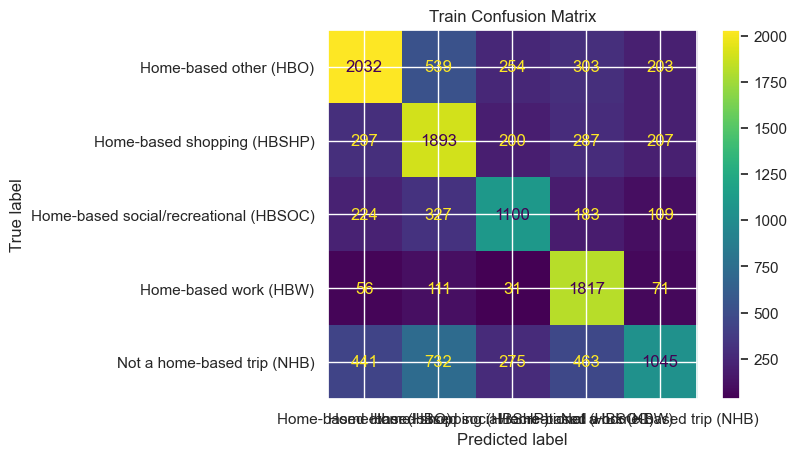

46/46 [==============================] - 0s 6ms/step


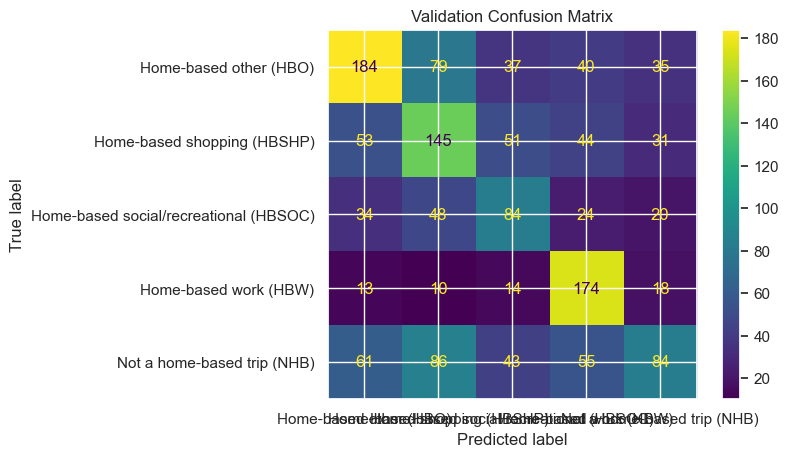

195/195 [==============================] - 1s 3ms/step


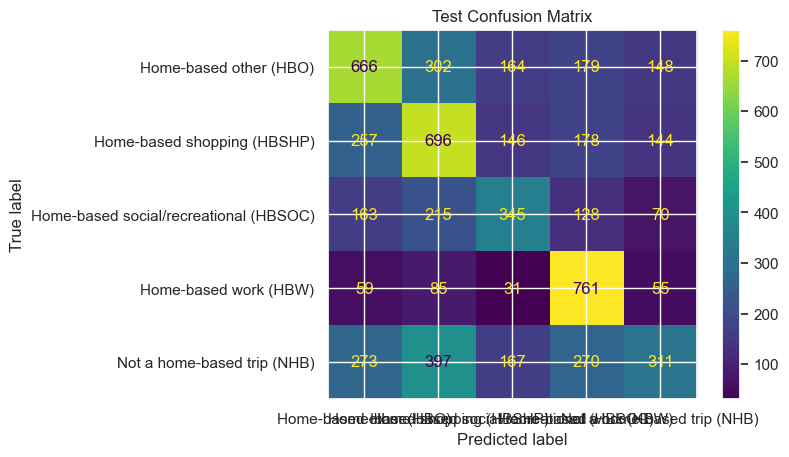

In [129]:
# Evaluate model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Train Accuracy: {model.evaluate(x_train, y_train)[1]}")
print(f"Validation Accuracy: {model.evaluate(x_val, y_val)[1]}")
print(f"Test Accuracy: {accuracy}")

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Train confusion matrix
predictions = model.predict(x_train)
predictions = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_train, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.title("Train Confusion Matrix")
plt.show()

# Validation confusion matrix
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_val, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.title("Validation Confusion Matrix")
plt.show()

# Test confusion matrix
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.title("Test Confusion Matrix")
plt.show()